# E-commerce проект №1

**Цель проекта:** сформулировать рекомендации маркетплейсу на основе анализа данных.
<!--  -->

**Задачи проекта:** проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько было пользователей, которые совершили покупку только один раз?

<!--  -->

2. Сколько заказов в месяц в среднем не доставляется по разным причинам? Вывести детализацию по причинам.

<!--  -->

3. По каждому товару определить в какой день недели товар чаще всего покупается.

<!--  -->

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

<!--  -->

5. Выполнить когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на третий месяц.

<!--  -->

6. Построить RFM-сегментацию пользователей для качественной оценки аудитории.

**Описание колонок в таблицах с данными маркетплейса:**

**olist_customers_datase.csv** — таблица с уникальными идентификаторами пользователей

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

**olist_orders_dataset.csv** —  таблица заказов

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

**olist_order_items_dataset.csv** —  товарные позиции, входящие в заказы

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

**Уникальные статусы заказов в таблице olist_orders_dataset:**

created —  создан

approved —  подтверждён

invoiced —  выставлен счёт

processing —  в процессе сборки заказа

shipped —  отгружен со склада

delivered —  доставлен пользователю 

unavailable —  недоступен

canceled —  отменён

## Этап 1. Настройка среды

In [1]:
# Импортирую необходимые библиотеки.
import pandas as pd 
import requests 
from urllib.parse import urlencode 

import warnings
warnings.simplefilter(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
 
import datetime as dt

from operator import attrgetter

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" # для отображения всех выводов ячейки

In [2]:
# Для таблицы с уникальными идентификаторами пользователей.

# Ипользую api. 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_customers = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
 
# Получаю url. 
final_url_customers = base_url + urlencode(dict(public_key = public_key_customers)) 
response_customers = requests.get(final_url_customers) 
download_url_customers = response_customers.json()['href'] 
 
# Загружаю файл в датафрейм df_customers. 
download_response_customers = requests.get(download_url_customers) 
df_customers = pd.read_csv(download_url_customers, sep = ',')

In [3]:
# Для таблицы заказов.

# Ипользую api. 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_orders = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
 
# Получаю url. 
final_url_orders = base_url + urlencode(dict(public_key = public_key_orders)) 
response_orders = requests.get(final_url_orders) 
download_url_orders = response_orders.json()['href'] 

# Сохраняю названия колонок с таймстэмпами.
columns_list = ['order_purchase_timestamp', 'order_approved_at',
                'order_delivered_carrier_date', 'order_delivered_customer_date', 
                'order_estimated_delivery_date']
 
# Загружаю файл в датафрейм df_orders. 
download_response_orders = requests.get(download_url_orders) 
df_orders = pd.read_csv(download_url_orders, sep = ',', parse_dates = columns_list)

In [4]:
# Для таблицы с товарными позициями, входящими в заказы.

# Ипользую api. 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_order_items = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'
 
# Получаю url. 
final_url_order_items = base_url + urlencode(dict(public_key = public_key_order_items)) 
response_order_items = requests.get(final_url_order_items) 
download_url_order_items = response_order_items.json()['href'] 
 
# Загружаю файл в датафрейм df_order_items. 
download_response_order_items = requests.get(download_url_order_items) 
df_order_items = pd.read_csv(download_url_order_items, sep = ',', parse_dates = ['shipping_limit_date'])

## Этап 2. Проведение EDA

### Исследую датафрейм df_customers

In [5]:
# Вывожу на экран первые 2 строки датасета.

df_customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [6]:
# Использую метод info, чтобы посмотреть верхнеуровневую информацию о датасете. 
# Отмечаю, что нет пропусков и пустых клеток в df_customers.

df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
# Замечаю, что уникальных пользователей всего 96096.

df_customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

### Исследую датафрейм df_orders

In [8]:
df_orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


In [9]:
# Видно, что в некоторых столбцах информация отсутствует. 

df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [10]:
# Выясняю точное количество пропусков в трех столбцах. 

df_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Можно предположить, что по 160 заказам еще нет подтверждения оплаты, 1783 заказов еще не переданы в логистическую службу, 2965 заказов еще не доставлены до пользователей.

In [11]:
# Выясняю, что уникальных значений в столбце order_status всего 8. 

df_orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [12]:
# Вывожу эти 8 значений. Они могут пригодиться в дальнейшем.

df_orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

### Исследую датафрейм df_order_items

In [13]:
df_order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [14]:
# Отмечаю, что нет пропусков и пустых клеток в df_order_items.

df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [15]:
# Отмечаю, что количество уникальных товаров в датасете равно 32951.

df_order_items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

Также отмечаю, что количество уникальных значений в столбце order_id (98666) в датасете df_order_items меньше, чем в датасете df_orders (99441).

In [16]:
# Вывожу описательную статистику по столбцам price и freight_value.

df_order_items.describe()

,order_item_id,shipping_limit_date,price,freight_value
count,112650.000000,112650,112650.000000,112650.000000
mean,1.197834,2018-01-07 15:36:52.192685312,120.653739,19.990320
min,1.000000,2016-09-19 00:15:34,0.850000,0.000000
25%,1.000000,2017-09-20 20:57:27.500000,39.900000,13.080000
50%,1.000000,2018-01-26 13:59:35,74.990000,16.260000
75%,1.000000,2018-05-10 14:34:00.750000128,134.900000,21.150000
max,21.000000,2020-04-09 22:35:08,6735.000000,409.680000
std,0.705124,NaN,183.633928,15.806405


## Этап 3. Формулировка понятий

**Что должно считаться покупкой?**

Можно предположить, что покупкой могут считаться те заказы, у которых одновременно выполняются следующие условия:
1. Есть оплата за заказ.
2. Нет статуса заказа "отменен", т.е. order_status не равен canceled. 

Можно проследить оплату заказа лишь по столбцу order_approved_at (время подтверждения оплаты заказа), хотя факт оплаты заказа может быть раньше даты подтверждения оплаты, т.к. на обработку подтверждения оплаты может уйти время. Также необходимо отметить, что null значения в столбце order_approved_at могут быть из-за технических сбоев, а не потому, что оплаты за заказ не было.

Поэтому принимаю допущение, что факт оплаты заказа приравнивается факту наличия времени подтверждения оплаты заказа, т.е. order_approved_at не равен NaT.

In [17]:
# Проверяю распределение заказов по статусам заказа. 625 заказов отменены.

df_orders.groupby('order_status')\
    .agg({'order_id' : 'count'})\
    .rename(columns = {'order_id' : 'order_count'})

,order_count
order_status,
approved,2
canceled,625
created,5
delivered,96478
invoiced,314
processing,301
shipped,1107
unavailable,609


In [18]:
# Фильтрую заказы со статусом created и вижу, что в столбце order_approved_at есть пустые клетки.
# Скорее всего, это означает, что по данным заказам еще нет подтверждения оплаты.

df_orders.query('order_status == "created"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
7434,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11
9238,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07
21441,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12
55086,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08
58958,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01


In [19]:
# Заказы со статусом approved оплачены.

df_orders.query('order_status == "approved"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
44897,a2e4c44360b4a57bdff22f3a4630c173,8886130db0ea6e9e70ba0b03d7c0d286,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,NaT,NaT,2017-03-01
88457,132f1e724165a07f6362532bfb97486e,b2191912d8ad6eac2e4dc3b6e1459515,approved,2017-04-25 01:25:34,2017-04-30 20:32:41,NaT,NaT,2017-05-22


In [20]:
# Заказы со статусом invoiced оплачены.

df_orders.query('order_status == "invoiced"')\
    .isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     314
order_delivered_customer_date    314
order_estimated_delivery_date      0
dtype: int64

In [21]:
# Заказы со статусом processing оплачены.

df_orders.query('order_status == "processing"')\
    .isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     301
order_delivered_customer_date    301
order_estimated_delivery_date      0
dtype: int64

In [22]:
# Заказы со статусом shipped оплачены.

df_orders.query('order_status == "shipped"')\
    .isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        0
order_delivered_customer_date    1107
order_estimated_delivery_date       0
dtype: int64

In [23]:
# У всех заказов со статусом delivered есть подтверждение оплаты за исключением 14 заказов.

df_orders.query('order_status == "delivered"')\
    .isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [24]:
# Вывожу эти 14 заказов.

df_orders.query('order_status == "delivered" and order_approved_at == "NaT"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


Если бы у части заказов был наложенный платеж или оплата производилась бы при получении заказа в ПВЗ, то даты в столбцах order_approved_at и order_delivered_customer_date либо полностью совпали бы, либо разница в датах была бы незначительной. Поэтому пропуски в столбце order_approved_at могут быть объяснены техническим сбоем. Следовательно, необходимо включить эти 14 заказов в таблицу покупок.

In [25]:
# Вывожу айди этих 14 заказов и сохраняю их в новую переменную included_orders.

included_orders = df_orders.query('order_status == "delivered" and order_approved_at == "NaT"')\
    .order_id\
    .tolist()

included_orders

['e04abd8149ef81b95221e88f6ed9ab6a',
 '8a9adc69528e1001fc68dd0aaebbb54a',
 '7013bcfc1c97fe719a7b5e05e61c12db',
 '5cf925b116421afa85ee25e99b4c34fb',
 '12a95a3c06dbaec84bcfb0e2da5d228a',
 'c1d4211b3dae76144deccd6c74144a88',
 'd69e5d356402adc8cf17e08b5033acfb',
 'd77031d6a3c8a52f019764e68f211c69',
 '7002a78c79c519ac54022d4f8a65e6e8',
 '2eecb0d85f281280f79fa00f9cec1a95',
 '51eb2eebd5d76a24625b31c33dd41449',
 '88083e8f64d95b932164187484d90212',
 '3c0b8706b065f9919d0505d3b3343881',
 '2babbb4b15e6d2dfe95e2de765c97bce']

In [26]:
# Заказы со статусом unavailable оплачены.

df_orders.query('order_status == "unavailable"')\
    .isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     609
order_delivered_customer_date    609
order_estimated_delivery_date      0
dtype: int64

Следовательно, к покупкам я буду относить заказы, у которых одновременно выполняются следующие условия:
1. Есть оплата за заказ, т.е. order_approved_at не равен NaT и включаю в покупки заказы с order_id равным @included_orders.
2. Нет статуса заказа "отменен", т.е. order_status не равен canceled.

In [27]:
# Фильтрую датасет df_orders по условиям, сохраняю его в новый датафрейм df_purchases и вывожу на экран.
# Делаю вывод, что 98811 заказов в датасете удовлетворяют данному определению покупок.

df_purchases = df_orders.query('order_status != "canceled" and order_approved_at != "NaN" or order_id == @included_orders')
df_purchases

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


In [28]:
# Проверяю количество уникальных значений в каждом столбце.

df_purchases.nunique()

order_id                         98811
customer_id                      98811
order_status                         6
order_purchase_timestamp         98252
order_approved_at                90301
order_delivered_carrier_date     80951
order_delivered_customer_date    95658
order_estimated_delivery_date      448
dtype: int64

In [29]:
# Проверяю какие статусы заказов попали в таблицу покупок.

df_purchases.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'approved'], dtype=object)

In [30]:
# Вывожу количество пропущенных значений в столбцах.

df_purchases.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date     1228
order_delivered_customer_date    2341
order_estimated_delivery_date       0
dtype: int64

## Этап 4. Поиск ответов

### Вопрос 1. Сколько было пользователей, которые совершили покупку только один раз? 

In [31]:
# Объединяю датафреймы df_purchases и df_customers и сохраняю их в новый датафрейм df_q1.

df_q1 = df_purchases.merge(df_customers, how='left', on='customer_id')
df_q1

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
98806,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
98807,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
98808,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
98809,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [32]:
# Проверяю df_q1 на наличие пропущенных значений.

df_q1.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date     1228
order_delivered_customer_date    2341
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [33]:
# Группирую покупки по уникальному идентификатору пользователя. Считаю количество покупок у каждого пользователя.

df_q1.groupby('customer_unique_id', as_index=False)\
    .agg({'order_id' : 'count'})\
    .rename(columns={'order_id' : 'purchase_count'})\
    .sort_values('purchase_count', ascending=False)

,customer_unique_id,purchase_count
52672,8d50f5eadf50201ccdcedfb9e2ac8455,17
23339,3e43e6105506432c953e165fb2acf44c,9
10290,1b6c7548a2a1f9037c1fd3ddfed95f33,7
75646,ca77025e7201e3b30c44b472ff346268,7
37594,6469f99c1f9dfae7733b25662e7f1782,7
...,...,...
32315,56509f7bc43892a0da09ee14f50a6f84,1
32314,564feb90710b4f84399f931fa97ea704,1
32313,564fb2956ed34f0a78c1cc37d731f3d9,1
32312,564f89ca1f5371992bf1fb87a0331ac3,1


In [34]:
# Фильтрую пользователей с 1 покупкой.

df_q1.groupby('customer_unique_id', as_index=False)\
    .agg({'order_id' : 'count'})\
    .rename(columns={'order_id' : 'purchase_count'})\
    .query('purchase_count == 1')

,customer_unique_id,purchase_count
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95551,fffcf5a5ff07b0908bd4e2dbc735a684,1
95552,fffea47cd6d3cc0a88bd621562a9d061,1
95553,ffff371b4d645b6ecea244b27531430a,1
95554,ffff5962728ec6157033ef9805bacc48,1


#### Ответ на первый вопрос: 
92633 пользователей совершили покупку только 1 раз. 

##### Выводы:
Из 96096 уникальных пользователей, 95556 (99.44%) совершили покупку. 

Из 95556 совершивших покупку пользователей, только 2923 (3.06%) пользователей совершили больше 1 покупки.

### Вопрос 2. Сколько заказов в месяц в среднем не доставляется по разным причинам? Вывести детализацию по причинам.

Наиболее очевидными причинами недоставки могут быть:
1. Заказ отменен.
2. Заказ недоступен.

In [35]:
# Так как меня интересуют заказы, а не покупки, беру датафрейм df_orders.
# Фильтрую df_orders по статусам canceled и unavailable и сохраняю в новый датафрейм df_q2.
# Добавляю столбец month, куда я вытаскиваю номера месяцев из order_purchase_timestamp (времени создания заказа).

df_q2 = df_orders.query('order_status == "canceled" or order_status == "unavailable"')
df_q2.insert(4, 'year_month', df_q2.order_purchase_timestamp.dt.strftime('%Y-%m'))
df_q2

,order_id,customer_id,order_status,order_purchase_timestamp,year_month,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11,2017-11-16 15:26:57,NaT,NaT,2017-12-05
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08,2018-08-07 04:10:26,NaT,NaT,2018-08-14
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01,2018-01-31 14:23:50,NaT,NaT,2018-02-16
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08,2017-08-17 00:15:18,NaT,NaT,2017-09-05
...,...,...,...,...,...,...,...,...,...
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01,2018-01-17 03:37:34,NaT,NaT,2018-02-06
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,2018-08,NaT,NaT,NaT,2018-10-01
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,2018-09,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [36]:
# Проверяю df_q2 на наличие пропущенных значений.

df_q2.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
year_month                          0
order_approved_at                 141
order_delivered_carrier_date     1159
order_delivered_customer_date    1228
order_estimated_delivery_date       0
dtype: int64

In [37]:
# Считаю количество заказов в разбивке по месяцам и статусам заказов. 
# Затем сортирую столбец month по возрастанию.
# Результат пересохраняю в df_q2.

df_q2 = df_q2.groupby(['year_month', 'order_status'], as_index=False)\
    .agg({'order_id': 'count'})\
    .rename(columns={'order_id': 'order_count'})\
    .sort_values('year_month', ascending=True)

df_q2

,year_month,order_status,order_count
0,2016-09,canceled,2
1,2016-10,canceled,24
2,2016-10,unavailable,7
3,2017-01,canceled,3
4,2017-01,unavailable,10
5,2017-02,canceled,17
6,2017-02,unavailable,45
7,2017-03,canceled,33
8,2017-03,unavailable,32
10,2017-04,unavailable,9


In [38]:
# Далее группирую по order_status и вывожу среднее значение для каждой группы.
# Округляю значения до целого.

df_q2.groupby('order_status', as_index=False)\
    .agg({'order_count': 'mean'})\
    .rename(columns={'order_count': 'order_count_mean'})\
    .round()

,order_status,order_count_mean
0,canceled,26.0
1,unavailable,29.0


In [39]:
# Результирующая выборка за 2017 содержит наиболее точный результат, так как содержит данные за весь год.   
df_q2.query('year_month.str.contains("2017")', engine='python')\
    .groupby('order_status', as_index=False)\
    .agg({'order_count': 'mean'})\
    .rename(columns={'order_count': 'order_count_mean'})\
    .round()

,order_status,order_count_mean
0,canceled,22.0
1,unavailable,38.0


#### Ответ на второй вопрос: 
В среднем в месяц заказы не доставляются, потому что они либо отменены (22 заказа), либо недоступны (38 заказов).

### Вопрос 3. По каждому товару определить в какой день недели товар чаще всего покупается.

In [40]:
# Объединяю датафреймы df_purchases и df_order_items и сохраняю их в новый датафрейм df_q3.
# Добавляю столбец weekday, куда я вытаскиваю названия дней недели из order_purchase_timestamp (времени создания заказа).

df_q3 = df_purchases.merge(df_order_items, how='left', on='order_id')
df_q3.insert(4, 'weekday', df_q3.order_purchase_timestamp.dt.day_name())
df_q3

,order_id,customer_id,order_status,order_purchase_timestamp,weekday,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,Monday,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,Tuesday,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,Wednesday,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,Saturday,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,Tuesday,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112709,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,Tuesday,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
112710,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,Sunday,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
112711,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,Monday,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
112712,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,Monday,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


In [41]:
# Проверяю количество уникальных значений в каждом столбце.

df_q3.nunique()

order_id                         98811
customer_id                      98811
order_status                         6
order_purchase_timestamp         98252
weekday                              7
order_approved_at                90301
order_delivered_carrier_date     80951
order_delivered_customer_date    95658
order_estimated_delivery_date      448
order_item_id                       21
product_id                       32735
seller_id                         3056
shipping_limit_date              92890
price                             5934
freight_value                     6985
dtype: int64

In [42]:
# Вывожу количество пропущенных значений в столбцах.

df_q3.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
weekday                             0
order_approved_at                  15
order_delivered_carrier_date     1333
order_delivered_customer_date    2525
order_estimated_delivery_date       0
order_item_id                     606
product_id                        606
seller_id                         606
shipping_limit_date               606
price                             606
freight_value                     606
dtype: int64

In [43]:
# Группирую по столбцам product_id и weekday. 
# Беру столбец order_purchase_timestamp, т.к. в нем нет пропущенных значений, и считаю количество заказов на каждый товар.
# Переименовываю столбец order_purchase_timestamp на count для удобства.
# Сортирую столбец count по убыванию.

df_q3 = df_q3.groupby(['product_id', 'weekday'], as_index=False)\
    .agg({'order_purchase_timestamp': 'count'})\
    .rename(columns={'order_purchase_timestamp': 'count'})\
    .sort_values('count', ascending=False)

df_q3

,product_id,weekday,count
15817,422879e10f46682990de24d770e7f83d,Wednesday,93
36314,99a4788cb24856965c36a24e339b6058,Monday,92
40829,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
40825,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
40830,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
...,...,...,...
23899,6432d844f2be41bb6f2fd279e23415da,Friday,1
23901,6435535083cf42eb1ce5d96f2c4d3482,Tuesday,1
23902,6435be64ad92f52631170f9a92718a99,Sunday,1
23904,64367bed3ed96fd9381676fbe33b6443,Sunday,1


In [44]:
# Теперь для каждого товара вывожу максимальное количество заказов.
# Замечаю, что например product_id aca2eb7d00ea1a7b8ebd4e68314663af был самым популярным среди покупателей в разные дни.

df_q3['count_max'] = df_q3.groupby(['product_id'])['count'].transform(max)
df_q3

,product_id,weekday,count,count_max
15817,422879e10f46682990de24d770e7f83d,Wednesday,93,93
36314,99a4788cb24856965c36a24e339b6058,Monday,92,92
40829,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89,89
40825,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87,89
40830,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85,89
...,...,...,...,...
23899,6432d844f2be41bb6f2fd279e23415da,Friday,1,1
23901,6435535083cf42eb1ce5d96f2c4d3482,Tuesday,1,1
23902,6435be64ad92f52631170f9a92718a99,Sunday,1,1
23904,64367bed3ed96fd9381676fbe33b6443,Sunday,1,1


In [45]:
# Это нужно учесть. Поэтому сохраняю значения из столбцов count и count_max в переменные.

count = df_q3['count']
count_max = df_q3['count_max']

In [46]:
# Фильтрую и оставляю для каждого товара день недели с максимальным количеством продаж.

df_q3.query('@count == @count_max')

,product_id,weekday,count,count_max
15817,422879e10f46682990de24d770e7f83d,Wednesday,93,93
36314,99a4788cb24856965c36a24e339b6058,Monday,92,92
40829,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89,89
20015,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76,76
12934,368c6c730842d78016ad823897a372db,Friday,67,67
...,...,...,...,...
23899,6432d844f2be41bb6f2fd279e23415da,Friday,1,1
23901,6435535083cf42eb1ce5d96f2c4d3482,Tuesday,1,1
23902,6435be64ad92f52631170f9a92718a99,Sunday,1,1
23904,64367bed3ed96fd9381676fbe33b6443,Sunday,1,1


#### Ответ на третий вопрос: 
Например, товар с product_id 422879e10f46682990de24d770e7f83d чаще всего покупается по средам.

По остальным товарам смотрите таблицу выше.

### Вопрос 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [47]:
# Объединяю датафреймы df_purchases и df_customers и сохраняю их в новый датафрейм df_q4.

df_q4 = df_purchases.merge(df_customers, how='left', on='customer_id')

In [48]:
# Проверяю количество уникальных значений в каждом столбце. 

df_q4.nunique()

order_id                         98811
customer_id                      98811
order_status                         6
order_purchase_timestamp         98252
order_approved_at                90301
order_delivered_carrier_date     80951
order_delivered_customer_date    95658
order_estimated_delivery_date      448
customer_unique_id               95556
customer_zip_code_prefix         14982
customer_city                     4117
customer_state                      27
dtype: int64

In [49]:
# Проверяю df_q4 на наличие пропущенных значений.

df_q4.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date     1228
order_delivered_customer_date    2341
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [50]:
# Создаю новые столбцы year_month и days_in_month, куда сохраняю год-месяц и количество дней в месяце соответственно.

df_q4.insert(4, 'year_month', df_purchases.order_purchase_timestamp.dt.strftime('%Y-%m'))
df_q4.insert(5, 'days_in_month', df_purchases.order_purchase_timestamp.dt.daysinmonth)
df_q4

,order_id,customer_id,order_status,order_purchase_timestamp,year_month,days_in_month,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10,31.0,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07,31.0,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08,31.0,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11,30.0,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02,28.0,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98806,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-05,31.0,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
98807,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-03,31.0,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
98808,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2018-07,31.0,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
98809,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2017-12,31.0,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [51]:
# Теперь проверяю диапазон дат.

df_q4.order_purchase_timestamp.describe()

count                            98811
mean     2017-12-31 11:16:41.585481216
min                2016-09-04 21:15:19
25%         2017-09-12 18:01:47.500000
50%                2018-01-18 21:27:36
75%                2018-05-04 14:27:40
max                2018-09-03 09:06:57
Name: order_purchase_timestamp, dtype: object

Датасет df_q4 охватывает период с 4 сентября 2016 по 3 сентября 2018, т.е. сентябрь 2016 и сентябрь 2018 это неполные месяцы.

In [52]:
# Поэтому сужаю диапазон дат.

df_q4 = df_q4.query('order_purchase_timestamp >= "2016-10-01" and order_purchase_timestamp < "2018-09-01"')
df_q4

,order_id,customer_id,order_status,order_purchase_timestamp,year_month,days_in_month,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10,31.0,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07,31.0,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08,31.0,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11,30.0,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02,28.0,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98806,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-05,31.0,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
98807,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-03,31.0,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
98808,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2018-07,31.0,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
98809,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2017-12,31.0,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [53]:
# Делаю группировку по столбцам customer_unique_id, year_month, days_in_month.
# Далее агрегирую по order_purchase_timestamp, т.к. у данного столбца нет пропущенных значений, 
# и считаю количество покупок.
# Переименовываю столбцы для удобства.
# Сортирую столбец purchases_per_month по убыванию значений.

df_q4 = df_q4.groupby(['customer_unique_id', 'year_month', 'days_in_month'], as_index=False)\
    .agg({'order_purchase_timestamp': 'count'})\
    .rename(columns={'order_purchase_timestamp': 'purchases_per_month'})\
    .sort_values('purchases_per_month', ascending=False)

df_q4

,customer_unique_id,year_month,days_in_month,purchases_per_month
90599,ec7f1811826ab04a27a92197bc40c888,2017-11,30.0,3
40837,6a6a7141119ceaeca4dfbae7a580a515,2018-05,31.0,3
70812,b8b3c435a58aebd788a477bed8342910,2017-07,31.0,3
77565,ca77025e7201e3b30c44b472ff346268,2017-11,30.0,3
23912,3e43e6105506432c953e165fb2acf44c,2018-08,31.0,3
...,...,...,...,...
32675,552e5e9ae196001a9749ec363892a7b3,2018-04,30.0,1
32674,552e3c7cefbf9414ad1fcd05756eea18,2018-06,30.0,1
32673,552dba3033a5799623de5709d29ad227,2017-03,31.0,1
32672,552d8ab3877d4823cc8413e0af262098,2018-05,31.0,1


In [54]:
# Считаю количество недель в каждом месяце, округляю до сотых и сохраняю результат в новую колонку number_of_weeks.

df_q4.insert(4, 'number_of_weeks', round(df_q4.days_in_month / 7, 2))

df_q4

,customer_unique_id,year_month,days_in_month,purchases_per_month,number_of_weeks
90599,ec7f1811826ab04a27a92197bc40c888,2017-11,30.0,3,4.29
40837,6a6a7141119ceaeca4dfbae7a580a515,2018-05,31.0,3,4.43
70812,b8b3c435a58aebd788a477bed8342910,2017-07,31.0,3,4.43
77565,ca77025e7201e3b30c44b472ff346268,2017-11,30.0,3,4.29
23912,3e43e6105506432c953e165fb2acf44c,2018-08,31.0,3,4.43
...,...,...,...,...,...
32675,552e5e9ae196001a9749ec363892a7b3,2018-04,30.0,1,4.29
32674,552e3c7cefbf9414ad1fcd05756eea18,2018-06,30.0,1,4.29
32673,552dba3033a5799623de5709d29ad227,2017-03,31.0,1,4.43
32672,552d8ab3877d4823cc8413e0af262098,2018-05,31.0,1,4.43


In [55]:
# Далее считаю количество совершенных в среднем покупок в неделю для каждого пользователя и округляю результат до сотых.
# Cохраняю результат в новую колонку purchases_per_week.

df_q4['purchases_per_week'] = round(df_q4.purchases_per_month / df_q4.number_of_weeks, 2)

df_q4

,customer_unique_id,year_month,days_in_month,purchases_per_month,number_of_weeks,purchases_per_week
90599,ec7f1811826ab04a27a92197bc40c888,2017-11,30.0,3,4.29,0.70
40837,6a6a7141119ceaeca4dfbae7a580a515,2018-05,31.0,3,4.43,0.68
70812,b8b3c435a58aebd788a477bed8342910,2017-07,31.0,3,4.43,0.68
77565,ca77025e7201e3b30c44b472ff346268,2017-11,30.0,3,4.29,0.70
23912,3e43e6105506432c953e165fb2acf44c,2018-08,31.0,3,4.43,0.68
...,...,...,...,...,...,...
32675,552e5e9ae196001a9749ec363892a7b3,2018-04,30.0,1,4.29,0.23
32674,552e3c7cefbf9414ad1fcd05756eea18,2018-06,30.0,1,4.29,0.23
32673,552dba3033a5799623de5709d29ad227,2017-03,31.0,1,4.43,0.23
32672,552d8ab3877d4823cc8413e0af262098,2018-05,31.0,1,4.43,0.23


#### Ответ на четвертый вопрос: 

Cмотрите таблицу ниже:

In [56]:
# Отбираю нужные столбцы для удобства и пересохраняю в тот же датафрейм.

df_q4 = df_q4[['customer_unique_id', 'year_month', 'purchases_per_week']].copy()
df_q4

,customer_unique_id,year_month,purchases_per_week
90599,ec7f1811826ab04a27a92197bc40c888,2017-11,0.70
40837,6a6a7141119ceaeca4dfbae7a580a515,2018-05,0.68
70812,b8b3c435a58aebd788a477bed8342910,2017-07,0.68
77565,ca77025e7201e3b30c44b472ff346268,2017-11,0.70
23912,3e43e6105506432c953e165fb2acf44c,2018-08,0.68
...,...,...,...
32675,552e5e9ae196001a9749ec363892a7b3,2018-04,0.23
32674,552e3c7cefbf9414ad1fcd05756eea18,2018-06,0.23
32673,552dba3033a5799623de5709d29ad227,2017-03,0.23
32672,552d8ab3877d4823cc8413e0af262098,2018-05,0.23


### Вопрос 5. Выполнить когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на третий месяц.

In [57]:
# Объединяю датафреймы df_purchases и df_customers и сохраняю их в новый датафрейм df_q5.

df_q5 = df_purchases.merge(df_customers, how='left', on='customer_id')

In [58]:
# Сохраняю в новый столбец purchase_month номер месяца.

df_q5['purchase_month'] = df_q5['order_purchase_timestamp'].dt.to_period('M')
df_q5

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98806,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03
98807,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,2018-02
98808,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,2017-08
98809,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2018-01


In [59]:
# Группирую по столбцу month, чтобы посмотреть диапазон годов-месяцев в рассматриваемом периоде.

df_q5.groupby('purchase_month', as_index=False)\
    .agg({'customer_unique_id': 'count'})

,purchase_month,customer_unique_id
0,2016-09,2
1,2016-10,300
2,2016-12,1
3,2017-01,797
4,2017-02,1763
5,2017-03,2649
6,2017-04,2386
7,2017-05,3671
8,2017-06,3229
9,2017-07,3998


In [60]:
# Так как нужен период с января по декабрь, оставляю записи только за 2017 год для дальнейшего анализа.
# Пересохраняю результат в тот же датафрейм df_q5.

df_q5 = df_q5.query('"2016-12" < purchase_month < "2018-01"')
df_q5

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017-07
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS,2017-04
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,2017-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98803,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT,2017-10
98804,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG,2017-01
98805,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,831ce3f1bacbd424fc4e38fbd4d66d29,5127,sao paulo,SP,2017-02
98806,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03


In [61]:
# Создаю новый столбец cohort на основе первой даты покупки.

df_q5['cohort'] = df_q5.groupby('customer_unique_id')['order_purchase_timestamp']\
    .transform('min')\
    .dt.to_period('M')

df_q5

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,purchase_month,cohort
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,2017-09
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,2017-11
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017-07,2017-07
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS,2017-04,2017-04
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,2017-05,2017-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98803,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT,2017-10,2017-10
98804,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG,2017-01,2017-01
98805,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,831ce3f1bacbd424fc4e38fbd4d66d29,5127,sao paulo,SP,2017-02,2017-02
98806,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03,2017-03


In [62]:
# Проверяю количество уникальных значений в каждом столбце. 

df_q5.nunique()

order_id                         44832
customer_id                      44832
order_status                         6
order_purchase_timestamp         44583
order_approved_at                42703
order_delivered_carrier_date     40864
order_delivered_customer_date    43016
order_estimated_delivery_date      266
customer_unique_id               43469
customer_zip_code_prefix         12185
customer_city                     3286
customer_state                      27
purchase_month                      12
cohort                              12
dtype: int64

In [63]:
# Проверяю df_q5 на наличие пропущенных значений.

df_q5.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date      876
order_delivered_customer_date    1406
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
purchase_month                      0
cohort                              0
dtype: int64

In [64]:
# Затем я агрегирую данные по cohort и purchase_month и подсчитываю количество уникальных клиентов в каждой группе.
# Результат сохраняю в новый датафрейм df_q5_cohort.

df_q5_cohort = df_q5.groupby(['cohort', 'purchase_month'])\
    .agg(n_customers=('customer_unique_id', 'nunique'))\
    .reset_index(drop=False)

df_q5_cohort

,cohort,purchase_month,n_customers
0,2017-01,2017-01,763
1,2017-01,2017-02,3
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3
...,...,...,...
72,2017-10,2017-11,31
73,2017-10,2017-12,11
74,2017-11,2017-11,7269
75,2017-11,2017-12,40


In [65]:
# Создаю столбец period_number.

df_q5_cohort['period_number'] = (df_q5_cohort.purchase_month - df_q5_cohort.cohort).apply(attrgetter('n'))
df_q5_cohort

,cohort,purchase_month,n_customers,period_number
0,2017-01,2017-01,763,0
1,2017-01,2017-02,3,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4
...,...,...,...,...
72,2017-10,2017-11,31,1
73,2017-10,2017-12,11,2
74,2017-11,2017-11,7269,0
75,2017-11,2017-12,40,1


In [66]:
# Создаю сводную таблицу cohort_pivot.

cohort_pivot = df_q5_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,763.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0
2017-02,1735.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,NaN
2017-03,2603.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN,NaN
2017-04,2335.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,NaN,NaN,NaN
2017-05,3571.0,17.0,18.0,14.0,11.0,12.0,15.0,6.0,NaN,NaN,NaN,NaN
2017-06,3126.0,14.0,11.0,13.0,8.0,12.0,11.0,NaN,NaN,NaN,NaN,NaN
2017-07,3869.0,20.0,13.0,10.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4162.0,28.0,14.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4113.0,28.0,22.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# Вывожу размер когорты в отдельную переменную.

cohort_size = cohort_pivot.iloc[:, 0]
cohort_size

cohort
2017-01     763.0
2017-02    1735.0
2017-03    2603.0
2017-04    2335.0
2017-05    3571.0
2017-06    3126.0
2017-07    3869.0
2017-08    4162.0
2017-09    4113.0
2017-10    4446.0
2017-11    7269.0
2017-12    5477.0
Freq: M, Name: 0, dtype: float64

In [68]:
# Создаю матрицу retention.

retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,1.0,0.003932,0.002621,0.001311,0.003932,0.001311,0.005242,0.001311,0.001311,NaN,0.003932,0.001311
2017-02,1.0,0.002305,0.002882,0.001153,0.004035,0.001153,0.002305,0.001729,0.001729,0.002305,0.001153,NaN
2017-03,1.0,0.004994,0.003458,0.003842,0.003458,0.001537,0.001537,0.003073,0.003458,0.000768,NaN,NaN
2017-04,1.0,0.005996,0.002141,0.001713,0.002998,0.002570,0.003426,0.002998,0.002998,NaN,NaN,NaN
2017-05,1.0,0.004761,0.005041,0.003920,0.003080,0.003360,0.004201,0.001680,NaN,NaN,NaN,NaN
2017-06,1.0,0.004479,0.003519,0.004159,0.002559,0.003839,0.003519,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005169,0.003360,0.002585,0.002843,0.002068,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006728,0.003364,0.002643,0.003604,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006808,0.005349,0.002918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


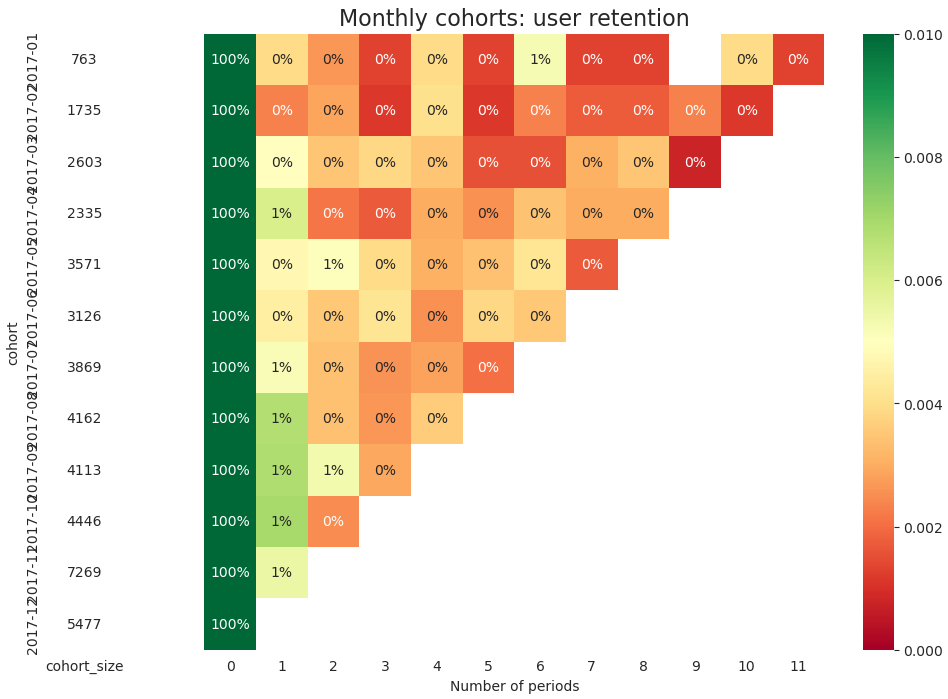

In [69]:
# Далее визуализирую данную татрицу с помощью тепловой карты.

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1], 
                vmin=0.0, 
                vmax=0.01)
    ax[1].set_title('Monthly cohorts: user retention', fontsize=16)
    ax[1].set(xlabel='Number of periods',
              ylabel='')

    
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])
    
    sns.set(rc={'figure.figsize':(18,6)}, style="whitegrid")
    
plt.show();

#### Ответ на пятый вопрос: 

Когорты 2017-05 и 2017-09 имеют наивысший retention на третий месяц.

##### Выводы:
В имеющихся данных нет значений retention > 1%, что логично, т.к. еще при ответе на первый вопрос было выяснено, что основная масса клиентов (99.44%) совершила только 1 покупку в период с сентября 2016 по сентябрь 2018.

### Вопрос 6. Построить RFM-сегментацию пользователей для качественной оценки аудитории. 

In [70]:
# Объединяю датафреймы df_purchases, df_customers, df_order_items в новый датафрейм df_q6.

df_q6 = df_purchases.merge(df_customers, how='left', on='customer_id')
df_q6 = df_q6.merge(df_order_items, how='left', on='order_id')
df_q6

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112709,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
112710,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
112711,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
112712,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


In [71]:
# Проверяю количество уникальных значений в каждом столбце.
# Замечаю, что уникальных значений в столбце customer_unique_id 95556, а это все пользователи совершившие покупку.

df_q6.nunique()

order_id                         98811
customer_id                      98811
order_status                         6
order_purchase_timestamp         98252
order_approved_at                90301
order_delivered_carrier_date     80951
order_delivered_customer_date    95658
order_estimated_delivery_date      448
customer_unique_id               95556
customer_zip_code_prefix         14982
customer_city                     4117
customer_state                      27
order_item_id                       21
product_id                       32735
seller_id                         3056
shipping_limit_date              92890
price                             5934
freight_value                     6985
dtype: int64

In [72]:
# Проверяю df_q6 на наличие пропущенных значений.
# Отмечаю, что в столбце price есть 606 пропусков.
# A в order_purchase_timestamp, order_id, customer_unique_id нет пропусков.

df_q6.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1333
order_delivered_customer_date    2525
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                     606
product_id                        606
seller_id                         606
shipping_limit_date               606
price                             606
freight_value                     606
dtype: int64

In [73]:
# Группирую по customer_unique_id, order_id, order_purchase_timestamp.
# Далее делаю агрегацию по столбцу price.
# Сортирую price по убыванию.

df_q6 = df_q6.groupby(['customer_unique_id', 'order_id', 'order_purchase_timestamp'], as_index = False)\
    .agg({'price': 'sum'})\
    .sort_values('price', ascending=False)

df_q6

,customer_unique_id,order_id,order_purchase_timestamp,price
3926,0a0a92112bd4c708ca5fde585afaa872,03caa2c082116e1d31e67e9ae3700499,2017-09-29 15:24:52,13440.0
45697,763c8b1c9c68a0229c42c9fc6f662b93,736e1922ae60d0d6a89247b851902527,2018-07-15 14:49:44,7160.0
85144,dc4802a71eae9be1dd28f5d788ceb526,0812eb902a67711a1cb742b3cdaa65ae,2017-02-12 20:37:36,6735.0
26911,459bef486812aa25204be022145caa62,fefacc66af859508bf1a7934eab1e97f,2018-07-25 18:10:17,6729.0
98518,ff4159b92c40ebe40454e3e6a7c35ed6,f5136e38d1a14a4dbd87dff67da82701,2017-05-24 18:14:34,6499.0
...,...,...,...,...
54847,8e465bae21753e53ec554a6bf0a0dca4,484ce4bf2067023e5184d003c41eb07a,2017-11-24 12:17:32,0.0
40563,68d891ce207863d0b5391a364d42cb6a,4ce5e2d15628c2277ca6ed81ee60f9de,2017-07-10 00:18:31,0.0
17252,2ca0a7618ffe667bca2d25dfe576e25b,a027b795d174ac4c8c7fd853838b5744,2017-12-12 14:07:04,0.0
56722,930c4390af58f67334447c3a1cf2ba36,86f0bcd9b426a2c1022ae317c7f27be6,2017-03-08 15:13:03,0.0


In [74]:
# Для удобства избавляюсь от времени и оставляю только дату в столбце order_purchase_timestamp.

df_q6['order_purchase_timestamp'] = pd.to_datetime(df_q6['order_purchase_timestamp']).dt.date
df_q6

,customer_unique_id,order_id,order_purchase_timestamp,price
3926,0a0a92112bd4c708ca5fde585afaa872,03caa2c082116e1d31e67e9ae3700499,2017-09-29,13440.0
45697,763c8b1c9c68a0229c42c9fc6f662b93,736e1922ae60d0d6a89247b851902527,2018-07-15,7160.0
85144,dc4802a71eae9be1dd28f5d788ceb526,0812eb902a67711a1cb742b3cdaa65ae,2017-02-12,6735.0
26911,459bef486812aa25204be022145caa62,fefacc66af859508bf1a7934eab1e97f,2018-07-25,6729.0
98518,ff4159b92c40ebe40454e3e6a7c35ed6,f5136e38d1a14a4dbd87dff67da82701,2017-05-24,6499.0
...,...,...,...,...
54847,8e465bae21753e53ec554a6bf0a0dca4,484ce4bf2067023e5184d003c41eb07a,2017-11-24,0.0
40563,68d891ce207863d0b5391a364d42cb6a,4ce5e2d15628c2277ca6ed81ee60f9de,2017-07-10,0.0
17252,2ca0a7618ffe667bca2d25dfe576e25b,a027b795d174ac4c8c7fd853838b5744,2017-12-12,0.0
56722,930c4390af58f67334447c3a1cf2ba36,86f0bcd9b426a2c1022ae317c7f27be6,2017-03-08,0.0


In [75]:
# Устанавливаю текущую дату. 
# Для этого датасета это будет самая свежая дата за рассматриваемый период c сентября 2016 по сентябрь 2018.

now = df_q6.order_purchase_timestamp.max()
now

datetime.date(2018, 9, 3)

In [76]:
# Определяю recency, frequency и monetary для каждого уникального пользователя, совершившего покупку.
# Сохраняю результат в новый датафрейм rfm_table.

rfm_table=df_q6.groupby('customer_unique_id', as_index = False)\
    .agg({'order_purchase_timestamp': lambda x: (now - x.max()).days, # Recency
                    'order_id': lambda x: len(x.unique()), # Frequency
                    'price': lambda x: x.sum()}) # Monetary

rfm_table

,customer_unique_id,order_purchase_timestamp,order_id,price
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00
...,...,...,...,...
95551,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00
95552,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89
95553,ffff371b4d645b6ecea244b27531430a,573,1,89.90
95554,ffff5962728ec6157033ef9805bacc48,124,1,115.00


In [77]:
# Для удобства переименовываю названия колонок.

rfm_table.rename(columns={'order_purchase_timestamp': 'recency', 
                                      'order_id': 'frequency',
                                      'price': 'monetary'}, inplace=True)
rfm_table

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00
...,...,...,...,...
95551,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00
95552,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89
95553,ffff371b4d645b6ecea244b27531430a,573,1,89.90
95554,ffff5962728ec6157033ef9805bacc48,124,1,115.00


In [78]:
# Для того, чтобы понять как пользователи распределены по frequency, делаю группировку.

rfm_table.groupby('frequency') \
         .agg({'customer_unique_id': 'count'})

,customer_unique_id
frequency,
1,92633
2,2687
3,187
4,30
5,8
6,6
7,3
9,1
17,1


Основная масса пользователей совершает покупку единожды.

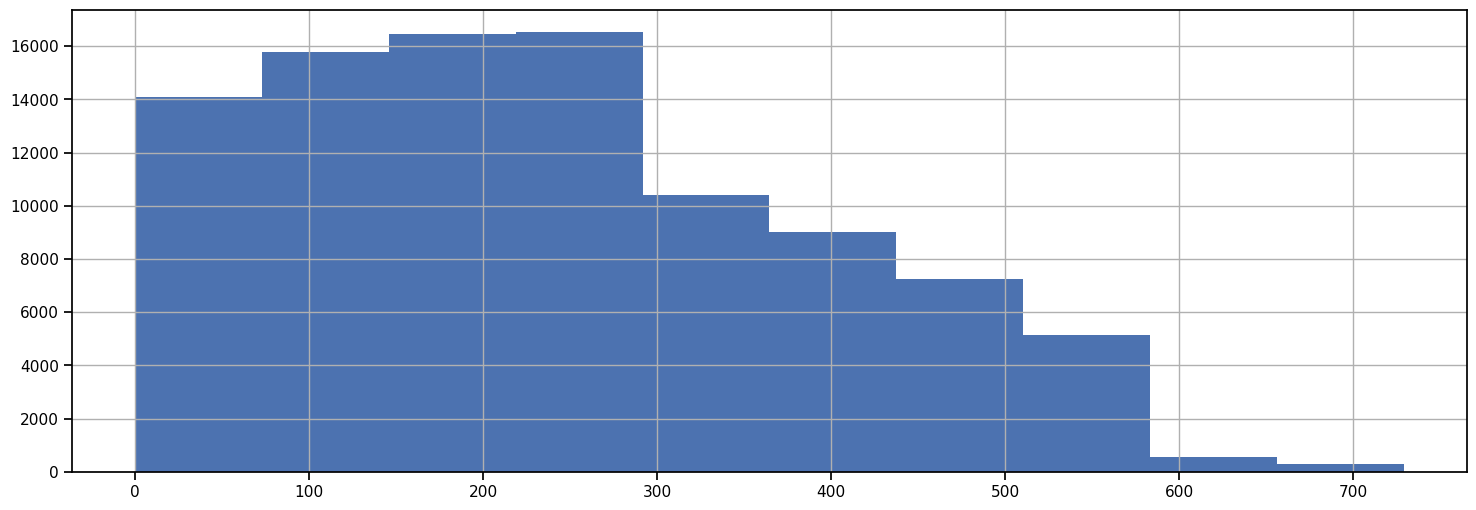

In [79]:
# Для наглядности вывожу распределение пользователей по дню последней покупки.

rfm_table.recency.hist()
plt.show();

In [80]:
# Проверяю тип данных в датафрейме rfm_table.

rfm_table.dtypes

customer_unique_id     object
recency                 int64
frequency               int64
monetary              float64
dtype: object

In [81]:
# Определяю границы метрик recency и monetary.

quantiles1 = rfm_table.quantile(q=[0.25, 0.75], numeric_only=True)
quantiles1

,recency,frequency,monetary
0.25,120.0,1.0,46.49
0.75,353.0,1.0,154.00


In [82]:
# Определяю границы метрики frequency.

quantiles2 = rfm_table.quantile(q=[0.97, 0.9997], numeric_only=True)
quantiles2

,recency,frequency,monetary
0.9700,550.0,2.0,597.931500
0.9997,699.0,4.0,3114.662335


In [83]:
# Строю 3 разные функции с условиями.

quantiles1
quantiles2

# RFM-сегментация

rfm_segment = rfm_table.copy()

# Функция для Recency
# Аргументы (x = value, p = recency, monetary, frequency, d = quartiles dict)
# для Recency чем больший срок прошел, тем хуже.
# где 1 - лучше, а 3 - хуже.

def r_class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.75]:
        return 2
    else:
        return 3
    
# Функция для Frequency
# Аргументы (x = value, p = recency, monetary, frequency, d = quartiles dict)
#для Frequency чем больше частота покупок, тем лучше.

def f_class(x,p,d):
    if x < d[p][0.97]:
        return 3
    elif x <= d[p][0.9997]:
        return 2
    else:
        return 1

# Функция для Monetary    
# Аргументы (x = value, p = recency, monetary, frequency, d = quartiles dict)
#для Monetary чем больше сумма покупок, тем лучше.

def m_class(x,p,d):
    if x <= d[p][0.25]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

# Добавляю в датафрейм новые строки.

rfm_segment['r_seg'] = rfm_segment['recency'].apply(r_class, args=('recency',quantiles1,))
rfm_segment['f_seg'] = rfm_segment['frequency'].apply(f_class, args=('frequency',quantiles2,))
rfm_segment['m_seg'] = rfm_segment['monetary'].apply(m_class, args=('monetary',quantiles1,))
rfm_segment['rfmclass'] = rfm_segment.r_seg.map(str) \
                        + rfm_segment.f_seg.map(str) \
                        + rfm_segment.m_seg.map(str)

,recency,frequency,monetary
0.25,120.0,1.0,46.49
0.75,353.0,1.0,154.00


,recency,frequency,monetary
0.9700,550.0,2.0,597.931500
0.9997,699.0,4.0,3114.662335


In [84]:
# Вывожу полученную RFM-сегментацию на экран.

rfm_segment

,customer_unique_id,recency,frequency,monetary,r_seg,f_seg,m_seg,rfmclass
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,3,2,132
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,3,3,133
2,0000f46a3911fa3c0805444483337064,542,1,69.00,3,3,2,332
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,3,3,233
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,3,1,231
...,...,...,...,...,...,...,...,...
95551,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00,3,3,1,331
95552,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89,2,3,2,232
95553,ffff371b4d645b6ecea244b27531430a,573,1,89.90,3,3,2,332
95554,ffff5962728ec6157033ef9805bacc48,124,1,115.00,2,3,2,232


In [85]:
# Вывожу количество уникальных значений в столбце rfmclass.

rfm_segment.rfmclass.nunique()

21

In [86]:
# Проверяю распределение количества клиентов по кластерам.

rfm_segment.groupby('rfmclass', as_index=False)\
    .agg({'customer_unique_id': 'count'})\
    .rename(columns={'customer_unique_id': 'count'})

,rfmclass,count
0,111,8
1,121,508
2,122,278
3,123,27
4,131,5525
5,132,11780
6,133,5917
7,211,10
8,221,887
9,222,554


**Сегментация:**
<!--  -->
1. **Ядро** — или стратегически важные клиенты. Покупают часто и на большие суммы. Хотят чувствовать исключительность своего положения: закрытый клуб, золотая карта — ценят вещи, которые показывают особый статус (111), т.е. recency = 1, frequency = 1, monetary = 1. Например, данный сегмент клиентов имеет границы метрик:
- recency <= 120 дней.
- frequency > 4 заказов в неделю.
- monetary > 154 руб. в неделю.
2. **Лояльные клиенты:** тратят немного, но часто. Нуждаются в постоянной поддержке контакта, бонусах, подарках при заказе  (112, 113, 122, 123).
3. **«Киты»:** тратят не слишком часто, но много. Скидки их интересуют в меньшей степени, чем ценный, возможно эксклюзивный товар (121).
4. **Новички:** могут, как уйти в категорию спящих, так и в категорию лояльных. Требуют пристального внимания, помощи в выборе товара, полезном контенте (131, 132, 133).
5. **Спящие:** когда-то были хорошими покупателями, но почему-то перестали проявлять активность. Можно попробовать вернуть былую свежесть вашим отношениям: предложить новый продукт, рассказать об акциях, выяснить, почему они потеряли интерес (211, 212, 213, 221, 222, 223, 231, 232, 233).
6. **Уходящие:** одной ногой уже за порогом. Следует узнать, почему не хотят пользоваться вашими услугами, предложить выгодную акцию, начислить бонусы, подарить промокод (311, 312, 313, 321, 322, 323, 331, 332).
7. **Потерянные клиенты.** Смириться и отпустить (333). 

In [87]:
# Присваиваю значениям из столбца rfmclass названия сегментов исходя из моей классификации выше.

rfm_segment.loc[rfm_segment['rfmclass'] == '111', 'segment'] = 'Ядро'
 
rfm_segment.loc[(rfm_segment['rfmclass'] == '112') 
                | (rfm_segment['rfmclass'] == '113') 
                | (rfm_segment['rfmclass'] == '122')
                | (rfm_segment['rfmclass'] == '123'), 'segment'] = 'Лояльные клиенты' 

rfm_segment.loc[rfm_segment['rfmclass'] == '121', 'segment'] = 'Киты'

rfm_segment.loc[(rfm_segment['rfmclass'] == '131') 
                | (rfm_segment['rfmclass'] == '132') 
                | (rfm_segment['rfmclass'] == '133'), 'segment'] = 'Новички' 

rfm_segment.loc[(rfm_segment['rfmclass'] == '211') 
                | (rfm_segment['rfmclass'] == '212') 
                | (rfm_segment['rfmclass'] == '213')
                | (rfm_segment['rfmclass'] == '221')
                | (rfm_segment['rfmclass'] == '222')
                | (rfm_segment['rfmclass'] == '223')
                | (rfm_segment['rfmclass'] == '231')
                | (rfm_segment['rfmclass'] == '232')
                | (rfm_segment['rfmclass'] == '233'), 'segment'] = 'Спящие'

rfm_segment.loc[(rfm_segment['rfmclass'] == '311') 
                | (rfm_segment['rfmclass'] == '312') 
                | (rfm_segment['rfmclass'] == '313')
                | (rfm_segment['rfmclass'] == '321')
                | (rfm_segment['rfmclass'] == '322')
                | (rfm_segment['rfmclass'] == '323')
                | (rfm_segment['rfmclass'] == '331')
                | (rfm_segment['rfmclass'] == '332'), 'segment'] = 'Уходящие'

rfm_segment.loc[rfm_segment['rfmclass'] == '333', 'segment'] = 'Потерянные клиенты'

rfm_segment.head()

,customer_unique_id,recency,frequency,monetary,r_seg,f_seg,m_seg,rfmclass,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,1,3,2,132,Новички
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,1,3,3,133,Новички
2,0000f46a3911fa3c0805444483337064,542,1,69.00,3,3,2,332,Уходящие
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,3,3,233,Спящие
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,3,1,231,Спящие


In [88]:
rfm_segment.groupby('segment', as_index=False)\
    .agg({'customer_unique_id': 'count'})\
    .rename(columns={'customer_unique_id': 'count'})\
    .sort_values('count', ascending=False)

,segment,count
4,Спящие,47689
2,Новички,23222
5,Уходящие,17653
3,Потерянные клиенты,6171
0,Киты,508
1,Лояльные клиенты,305
6,Ядро,8


#### Ответ на шестой вопрос: 

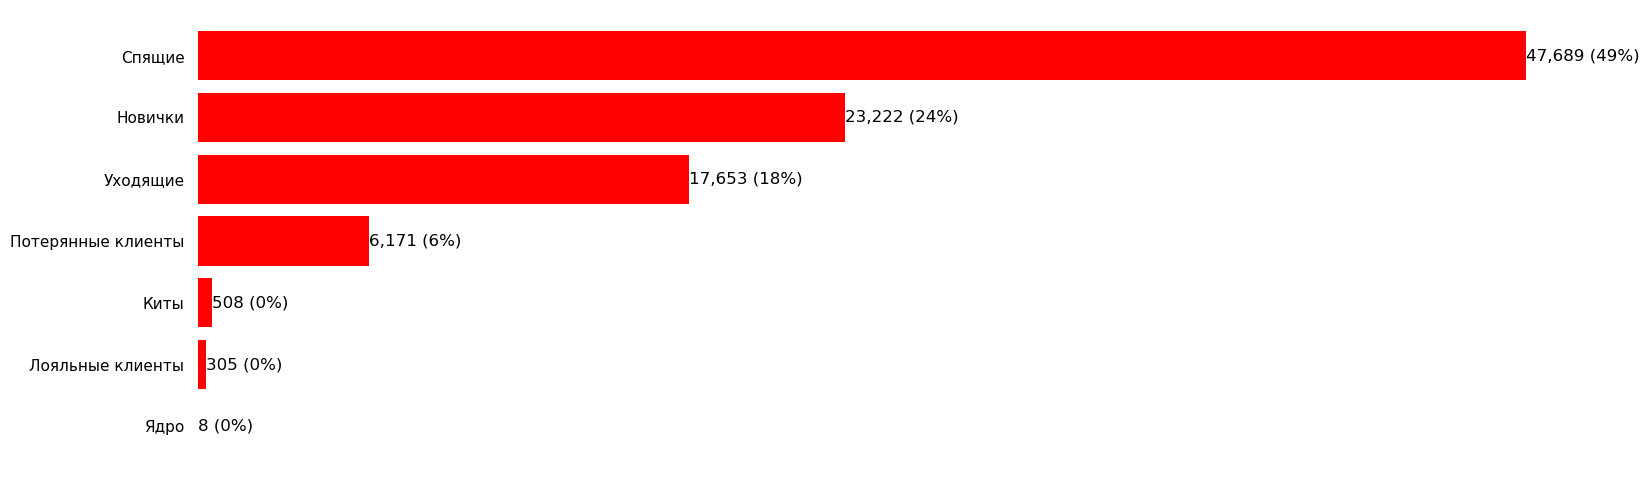

In [89]:
# Для наглядности визуализирую результаты сегментации.

InteractiveShell.ast_node_interactivity = "last_expr"
segments_counts = rfm_segment['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='red')

ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)

ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
plt.show();

Из графика выше видно, что основная масса клиентов маркетплейса относится к сегменту спящих клиентов. Новички составляют 24%, а уходящие клиенты - 18%. Постоянных клиентов в лице "ядра" и "лояльных" у маркетплейса практически нет (менее 1%). Потеряно 6% клиентов.

## Этап 5. Рекомендации

1. Выяснить у спящих клиентов почему они потеряли интерес и разработать акционные предложения с учетом их ответов.
2. Необходимо простимулировать новичков на повторную покупку, нужно обязательно проинформировать их о выгодах маркетплейса (программы лояльности, скидки от партнеров, подарки к праздникам, розыгрыши призов и т.п.), которые помогут заинтересовать их сделать вторую, третью покупку и стать в перспективе лояльными клиентами.
3. Напомнить о маркетплейсе уходящим клиентам. Выяснить почему они реже стали совершать покупки и разработать акционные предложения с учетом их ответов.
4. Пересмотреть акционные предложения для "китов", лояльных клиентов и "ядра".